Use the annotated data to train a model to classify the remaining unlabelled pixels.

In [1]:
import os
import glob
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np

In [2]:
import platform
platform.system()

if platform.system() == 'Darwin':
    is_mac = True

In [3]:
if not is_mac:
    from google.colab import drive
    drive.mount('/content/gdrive')

In [4]:
if is_mac:
    #image_path = '/Users/Mark/fruitpunch/coral_detection/data/'
    #annot_path = image_path
    image_path = '/Users/Mark/Google Drive/My Drive/Reef Support Benthic Data/SEAVIEW/PAC_AUS/'
    annot_path = '/Users/Mark/Google Drive/My Drive/Reef Support Benthic Data/SEAVIEW/tabular-data/'
else:
    image_path = '/content/gdrive/MyDrive/Reef Support Benthic Data/SEAVIEW/PAC_AUS/'
    annot_path = '/content/gdrive/MyDrive/Reef Support Benthic Data/SEAVIEW/tabular-data/'

In [5]:
#image_files = glob.glob(image_path + 11*'?' + '.jpg')
#print(f"{len(image_files)} images found")

In [6]:
annot_file = 'annotations_PAC_AUS.csv'
df = pd.read_csv(annot_path + annot_file, index_col=0)
df.shape

(186420, 7)

In [7]:
# sometimes an x,y label coordinate is outside the allowable values (based on the image dimensions)
df.drop(index=[13002079901, 13002086701, 15033259202], inplace=True)
df.shape

(186120, 7)

In [8]:
df.drop_duplicates(inplace=True)

In [9]:
# select N images randomly 
N = 20

keep = random.sample(df.index.unique().to_list(), N)
df = df.loc[keep]
df.shape

(1436, 7)

In [10]:
# index column was set to be the `quadratid`
# this numbers refers to the name of the image
# create a list of photo quadratids to pare down the annotations data frame
# so it contains only the relevant data# create list of images to read from ids in label file
ids = df.index.unique().to_list()
image_files = [image_path + str(id) + '.jpg' for id in ids]
len(ids)

20

In [12]:
# now loop over the images, and extract the pixel rgb values from the label coordinates
    
df[['r','g','b']] = int(0)

for ctr, image_file in enumerate(image_files):
    
    id = int(os.path.basename(image_file).rstrip('.jpg'))

    print(f'{ctr+1}/{len(image_files)} {image_file}',end='\r') 
  
    img = mpimg.imread(image_file)

    df.loc[id,['r','g','b']] = img[df.loc[id]['y'], df.loc[id]['x'], :]
    #df.loc[id,['r','g','b']] = img[df.loc[id]['x'], df.loc[id]['y'], :]

Now attempt to train a model on Algae vs non-Algae

In [13]:
df['func_group'].value_counts()

Hard Coral             732
Algae                  657
Soft Coral              33
Other Invertebrates      9
Other                    5
Name: func_group, dtype: int64

In [14]:
# define the target as coral or other
df['is_coral'] = df['func_group'].str.contains('Coral')

In [17]:
df['is_coral'].value_counts()

True     765
False    671
Name: is_coral, dtype: int64

Now the modelling

In [18]:
# using is_coral as target
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df[['r','g','b']], 
                                                    df['is_coral'], 
                                                    train_size=0.7)

In [19]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier().fit(X_train, y_train)

In [20]:
rfc.score(X_test, y_test)

0.6890951276102089

In [21]:
# plot a randomly selected example

example_image = random.choice(image_files)

id = int(os.path.basename(example_image).rstrip('.jpg'))

# read rgb image
img = mpimg.imread(example_image)

# predict coral or not coral
y_pred = rfc.predict(img.reshape((-1,3))).reshape(img.shape[0:-1])

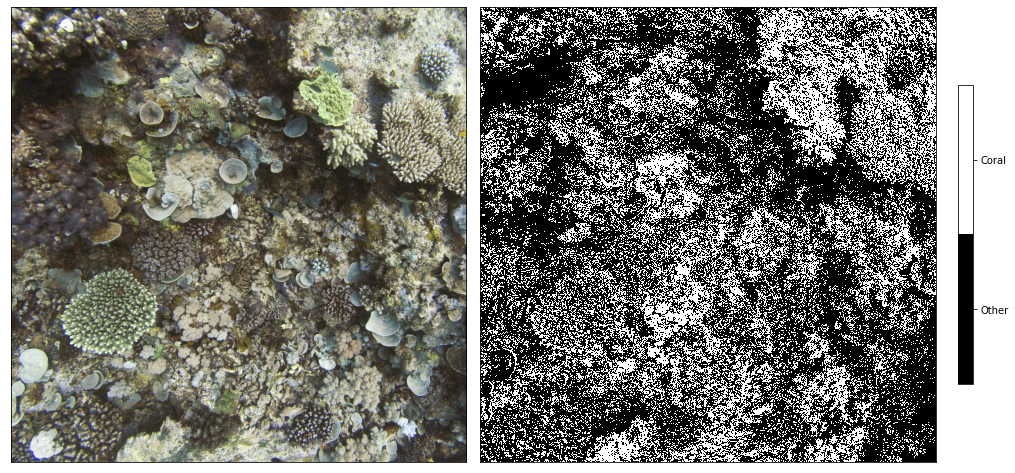

In [24]:
# make the figure

import matplotlib.colors
cmap = matplotlib.colors.ListedColormap(['black','white'])

fig, ax = plt.subplots(1,2,figsize=(14,7), constrained_layout=True)

ax[0].imshow(img);
im = ax[1].imshow(y_pred, cmap=cmap, interpolation='None', vmin=0, vmax=1);

for tax in ax:
    tax.axes.xaxis.set_visible(False)
    tax.axes.yaxis.set_visible(False)

cbar = fig.colorbar(im, ax=ax[1], shrink=0.6, ticks=[0.25, 0.75]);
cbar.ax.set_yticklabels(['Other','Coral']);

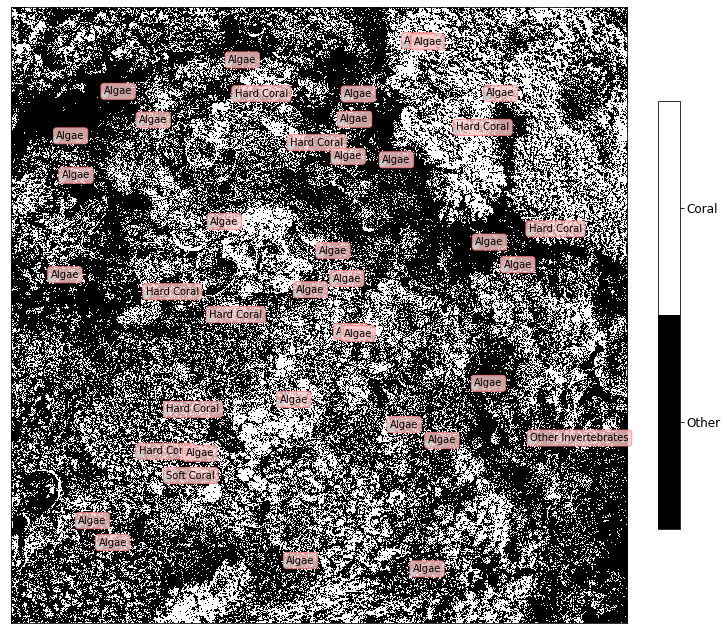

In [25]:
fig, ax = plt.subplots(1,1,figsize=(10,10), constrained_layout=True)
ax.imshow(y_pred, cmap=cmap, interpolation='None');
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

cbar = fig.colorbar(im, ax=ax, shrink=0.6, ticks=[0.25, 0.75]);
cbar.ax.set_yticklabels(['Other','Coral'], fontsize=12);

id = int(os.path.basename(example_image).rstrip('.jpg'))

ax.scatter(df.loc[id,"x"], df.loc[id,"y"], color="c");

for k, s in enumerate(df.loc[id]['func_group']):
    x = df.loc[id]['x'].iloc[k]
    y = df.loc[id]['y'].iloc[k]
    plt.text(x, y, s, color='k', fontsize=10, 
                      bbox=dict(boxstyle="round", 
                      ec=(1., 0.5, 0.5),
                      fc=(1., 0.8, 0.8),
                      alpha=0.8))

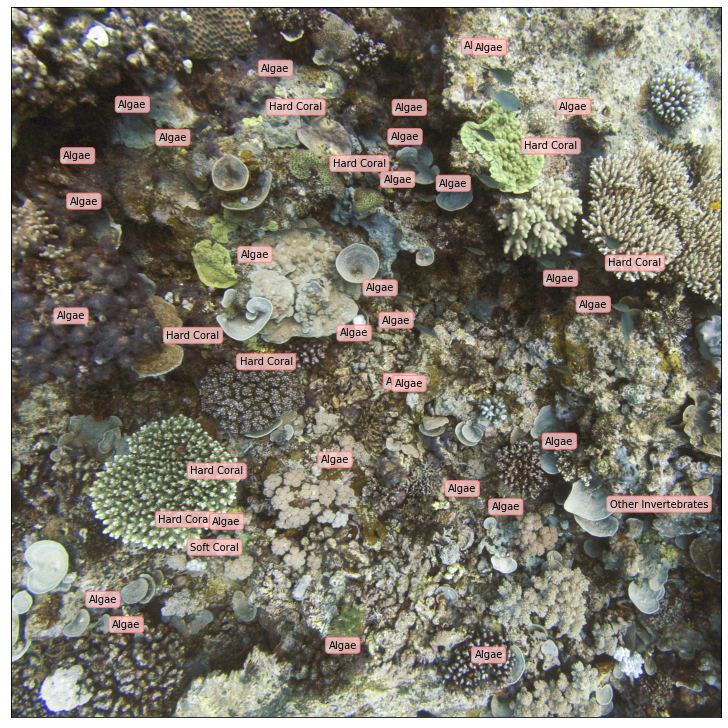

In [27]:
fig, ax = plt.subplots(1,1,figsize=(10,10), constrained_layout=True)
ax.imshow(img);
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

ax.scatter(df.loc[id,"x"], df.loc[id,"y"], color="c");

for k, s in enumerate(df.loc[id]['func_group']):
    x = df.loc[id]['x'].iloc[k]
    y = df.loc[id]['y'].iloc[k]
    plt.text(x, y, s, color='k', fontsize=10, 
                      bbox=dict(boxstyle="round", 
                      ec=(1., 0.5, 0.5),
                      fc=(1., 0.8, 0.8),
                      alpha=0.8))

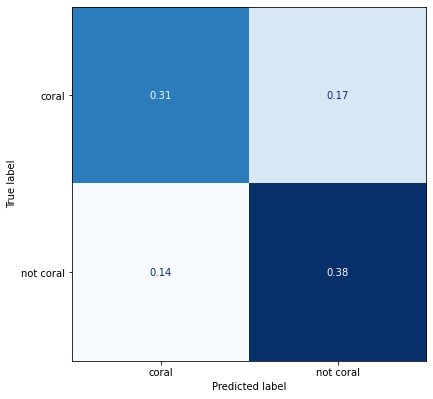

In [28]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

fig, ax = plt.subplots(1, 1, figsize=(6,6))
hdl = plot_confusion_matrix(rfc, X_test, y_test, ax=ax,
                          cmap=plt.cm.Blues, normalize='all',
                          display_labels=["coral","not coral"])
hdl.im_.colorbar.remove()
plt.tight_layout()
#fig.savefig("/Users/Mark/Desktop/conf_matrix.png", facecolor="w", edgecolor='none')
plt.show()

Some preliminary hyperparameter tuning

https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator=RandomForestClassifier(), 
                               param_distributions = random_grid, 
                               n_iter = 70, cv = 5, random_state = 42, n_jobs = -1)

In [ ]:
rf_random.fit(X_train, y_train)

In [ ]:
rf_random.best_params_

In [ ]:
base_model = RandomForestClassifier()
base_model.fit(X_train, y_train)

print(f'Base model test set accuracy: {100*np.round(base_model.score(X_test, y_test), 2) }%')

In [ ]:
tuned_model = rf_random.best_estimator_
tuned_model.fit(X_train, y_train)

print(f'Tuned model test set accuracy: {100*np.round(tuned_model.score(X_test, y_test), 2) }%')

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))
plot_confusion_matrix(tuned_model, X_test, y_test, ax=ax,
                      cmap=plt.cm.Blues, normalize='all',
                      display_labels=["coral","not coral"])
plt.tight_layout()
#fig.savefig("/Users/Mark/Desktop/conf_matrix.png", facecolor="w", edgecolor='none')
plt.show()